In [1253]:
import sys
import json

catchment_radius={'bus':800,'subway':1000}

params = {'catchment_radius':catchment_radius}
         
default = {'training_folder': '../../scenarios/montreal', 'params':params} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)


{'training_folder': '../../scenarios/montreal', 'params': {'catchment_radius': {'bus': 800, 'subway': 1000}}}


In [1254]:
import os
import time
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from syspy.spatial.spatial import add_geometry_coordinates
from sklearn.neighbors import NearestNeighbors

#num_cores = 1

In [1255]:
def get_epsg(lat: float, lon: float) -> int:
    '''
    lat, lon or y, x
    return EPSG in meter for a given (lat,lon)
    lat is north south 
    lon is est west
    '''
    return int(32700 - round((45 + lat) / 90, 0) * 100 + round((183 + lon) / 6, 0))


def get_catchment_dist(link: gpd.GeoDataFrame, catchment_radius: dict, default: float=500):
    route_type = link['route_type'].unique()
    if len(route_type)>1:
        print('multiple route type for a single route_id.. using first one for catchment radius')
    route_type = route_type[0]
    return catchment_radius.get(route_type, default)


def nearest(one, many, radius=100, geometry=False):
    try:
        # Assert df_many.index.is_unique
        assert one.index.is_unique
        assert many.index.is_unique
    except AssertionError:
        msg = 'Index of one or many should not contain duplicates'
        print(msg)
        warnings.warn(msg)
    many = add_geometry_coordinates(many.copy(), columns=['x_geometry', 'y_geometry'])
    one = add_geometry_coordinates(one.copy())
    
    x = many[['x_geometry', 'y_geometry']].values
    # Fit Nearest neighbors model
    #nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(x)
    nbrs = NearestNeighbors(radius=radius,algorithm='ball_tree').fit(x)


    # x = df_many[['x_geometry','y_geometry']].values
    y = one[['x_geometry', 'y_geometry']].values

    #distances, indices = nbrs.kneighbors(y,return_distance=True)
    distances, indices = nbrs.radius_neighbors(y, radius = radius, return_distance=True)

    indices = pd.DataFrame(indices)
    indices = pd.DataFrame(indices.stack(), columns=['index_nn']).reset_index().rename(
        columns={'level_0': 'ix_one', 'level_1': 'rank'}
    )
    indices['distances'] = distances
    return indices

In [1256]:
def create_mesh(zones: gpd.GeoDataFrame ,step: float = 0.01) -> gpd.GeoDataFrame:
    '''
    create a mesh in the zones total bbox at every step (in the units of the zones crs)
    step: degree if crs=4326, else meters. 0.01 deg ~ 1km
    '''
    x_max, y_max = zones.bounds.max()[['maxx','maxy']].values
    x_min, y_min = zones.bounds.min()[['minx','miny']].values

    points = []
    x = x_min
    while x<x_max:
        y = y_min
        while y<y_max:
            points.append(Point(x,y))
            y += step
        x += step
    points = gpd.GeoDataFrame(geometry=points,crs=zones.crs)
    points.index.name='index'
    return points

# https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python
from numba import jit, njit
import numba as nb
@jit(nopython=True)
def fast_point_in_polygon(x: float, y: float , poly: np.ndarray) -> bool:
    n = len(poly)
    inside = False
    p2x = 0.0
    p2y = 0.0
    xints = 0.0
    p1x,p1y = poly[0]
    for i in nb.prange(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y
        
    return inside


@njit(parallel=True)
def fast_points_in_polygon(points:np.ndarray, polygon:np.ndarray) -> np.ndarray:
    D = np.empty(len(points), dtype=nb.boolean) 
    for i in nb.prange(0, len(points)):
        D[i] = fast_point_in_polygon(points[i,0], points[i,1], polygon)
    return np.where(D)[0]

def points_in_polygon(points:np.ndarray, polygon:gpd.GeoDataFrame) -> np.ndarray:
    '''
    return a list of point in the polygon. values are the index in the points array.
    
    points:np.array[np.array[float,float]]
        list of all the points coords (x,y)
    polygon: gpd.GeoDataFrame
        geodataframe of multiples polygons.
    '''
    polygon = np.array([*polygon.exterior.coords])
    return fast_points_in_polygon(points,polygon)


def population_to_mesh(population: gpd.GeoDataFrame, step: float=0.01, col='population') ->  gpd.GeoDataFrame:
    '''
    create a mesh in the zones total bbox at every step (in the units of the zones crs)
    and assign the population to each node equaly (if 2 node in a zone. they have each 50% of the population)
    population:
        geodataframe with total population by zones ans zones geomerty
    step: 
        Distance betwwen each point degree if crs=4326, else meters. 0.01 deg ~ 1km
    '''
    import warnings
    warnings.filterwarnings('ignore')
    population=population.copy()
    if population.index.name != 'index':
        population.index.name = 'index'
    points = create_mesh(population, step=step)
    points_coords = np.array([point.coords[0] for point in points['geometry'].values])
    
    population['nodes'] = population['geometry'].apply(lambda x: points_in_polygon(points_coords,x))
    
    nodes = population.reset_index()[['index','nodes',col]].copy()
    nodes = nodes.explode('nodes').dropna()
    print(len(nodes[nodes['nodes'].duplicated()]),'nodes in multiple zones')
    
    
    zone_index_dict = nodes.set_index('nodes')['index'].to_dict()
    points['zone'] = points.index.map(zone_index_dict)

    pop_dict = nodes.set_index('nodes')[col].to_dict()
    points[col] = points.index.map(pop_dict)
    points = points.dropna()
    
    # get number of points per zones. divide population equaly between each points
    len_dict = points.groupby('zone')[col].agg(len).to_dict()
    points['num_points'] = points['zone'].apply(lambda x:len_dict.get(x))
    points[col] = points[col] / points['num_points']
    points = points.drop(columns = ['num_points'])
    
    print(len(population) - len(points['zone'].unique()),'unfounded zones. centroids will be added to the mesh')
    
    # find zones not in any points of the mesh.
    # add those zones centroid as a single mesh point.
    zones_list = points['zone'].unique()
    unfounded_zones = population.loc[~population.index.isin(zones_list)][['geometry',col]]
    unfounded_zones['geometry'] = unfounded_zones.centroid

    unfounded_zones = unfounded_zones.reset_index().rename(columns={'index':'zone'})
    points = pd.concat([points,unfounded_zones]).reset_index(drop=True)
    points.index.name='index'
    
    return points

In [1257]:
base_folder = argv['training_folder']
pt_folder = base_folder + '/inputs/pt/'
input_folder = base_folder +'/inputs/'
od_folder = base_folder + '/inputs/od/'
output_folder = base_folder +'/outputs/'
print(pt_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


../../scenarios/montreal/inputs/pt/


In [1258]:
catchment_radius = argv['params' ]['catchment_radius']
default_catchment_radius = 500

# inputs

In [1259]:
#cst_incline = argv['params' ]['constant']['cst_incline']
#cst_road = argv['params']['road_weight']
#cst_shared = argv['params']['shared_cycleway_weight']

In [1228]:
links = gpd.read_file(pt_folder + 'links.geojson') 
nodes = gpd.read_file(pt_folder + 'nodes.geojson')
links = links.set_index('index')
nodes = nodes.set_index('index')

In [1260]:
population = gpd.read_file(input_folder + 'population.geojson')
if 'index' in population.columns:
    population = population.set_index('index')
else:
    population.index.name='index'

In [1261]:
od_file = od_folder + 'od.geojson'
od_file_provided = os.path.isfile(od_file)
if od_file_provided:
    od_test = gpd.read_file(od_folder + 'od.geojson')
    if 'name' not in od_test.columns:
        od_test['name'] = od_test['index']
    od_test['name'] = od_test['name'].fillna(od_test['index'].astype(str))

# population preapation

In [1262]:
#get_epsg( -6.58316,106.79165)

In [1263]:
centroid = [*population.centroid[0].coords][0]

In [1264]:
crs = get_epsg(centroid[1],centroid[0])
crs

32618

In [1265]:
population['area (km2)'] = population.to_crs(crs).area*1e-6
population['area (km2)'].sum()

11574.507300457291

In [1266]:
population['population'] = population['density']*population['area (km2)']
population['population'].sum()

4884999.000000022

# population mesh

In [1267]:
#0.01 = 1km 0.005 = 500m
mesh = population_to_mesh(population, step=0.005, col = 'population')

7458 nodes in multiple zones
146 unfounded zones. centroids will be added to the mesh


In [1268]:
len(mesh)

46153

In [1269]:
mesh.to_file(output_folder + 'population_mesh.geojson',driver='GeoJSON')

In [1270]:
mesh

,geometry,zone,population
index,,,
0,POINT (-74.55201 45.60217),1629.0,8.763158
1,POINT (-74.55201 45.60717),1629.0,8.763158
2,POINT (-74.55201 45.61217),1629.0,8.763158
3,POINT (-74.55201 45.61717),1629.0,8.763158
4,POINT (-74.54701 45.59717),1629.0,8.763158
...,...,...,...
46148,POINT (-73.64835 45.70915),1456.0,0.000000
46149,POINT (-73.72020 45.55766),1641.0,0.000000
46150,POINT (-73.72406 45.56058),1642.0,0.000000


# catchment

In [1271]:
len(links['route_id'].unique())

495

In [1272]:
len(links['route_type'].unique())

3

In [1273]:
# find meters CRS
centroid = [*LineString(population.centroid.values).centroid.coords][0]
crs = get_epsg(centroid[1],centroid[0])

In [1274]:
# find TC nodes to mesh distance

In [1275]:
node_dist = nearest(nodes.to_crs(crs),mesh.to_crs(crs),3000)
node_dist = node_dist.rename(columns={'ix_one': 'node_index','index_nn':'mesh_index'}).drop(columns='rank')

In [1276]:
nodes_index_dict = nodes.reset_index()['index'].to_dict()
node_dist['node_index'] = node_dist['node_index'].apply(lambda x: nodes_index_dict.get(x))

In [1277]:
node_dist = node_dist.explode(['mesh_index','distances'])
population_dict = mesh['population'].to_dict()
node_dist['population'] = node_dist['mesh_index'].apply(lambda x: population_dict.get(x))


# metrics

In [1278]:
#init results dfs
df_route_id = pd.DataFrame(index=links['route_id'].unique())
df_route_id.index.name='route_id'

df_route_type = pd.DataFrame(index=links['route_type'].unique())
df_route_type.index.name='route_type'

In [1279]:
def get_catchment(col='route_id'):
    res={}
    for route_id in links[col].unique():
        link = links[links[col] == route_id]
        nodes_set = (set(link['a'].values).union(set(link['a'].values)))
        link_nodes = node_dist[node_dist['node_index'].isin(nodes_set)]

        dist = get_catchment_dist(link, catchment_radius, default_catchment_radius)
        link_nodes = link_nodes[link_nodes['distances'] <= dist]
        volume = link_nodes.drop_duplicates('mesh_index')['population'].sum()
        res[route_id] = volume
    return res

In [1280]:
res = get_catchment('route_id')

df_route_id['catchment'] = res
print(sum([item for key,item in res.items()]))

27547333.681666322


In [1281]:
res = get_catchment('route_type')

df_route_type['catchment'] = res
print(sum([item for key,item in res.items()]))

4484761.494205452


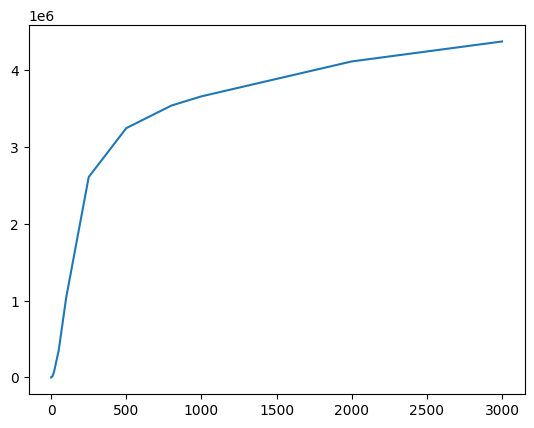

In [1282]:
res=[]
dists = [0,1,10,20,50,100,250,500,800,1000,2000,3000]
for dist in dists:
    nodes_set = (set(links['a'].values).union(set(links['a'].values)))
    link_nodes = node_dist[node_dist['node_index'].isin(nodes_set)]
    link_nodes = link_nodes[link_nodes['distances']<dist]
    volume = link_nodes.drop_duplicates('mesh_index')['population'].sum()
    res.append(volume)
plt.plot(dists,res)

# frequency

In [1283]:
links['frequency'] = 1/links['headway']

In [1284]:
def get_frequency(col='route_id'):
    res={}
    for route_id in links[col].unique():
        link = links[links[col] == route_id]
        vol = link.groupby('trip_id')['frequency'].agg(np.mean).mean()*3600
        res[route_id] = vol
    return res

In [1285]:
res = get_frequency('route_id')

df_route_id['frequency (veh/hours)'] = res
print(sum([item for key,item in res.items()]))

nan


In [1286]:
res = get_frequency('route_type')

df_route_type['frequency (veh/hours)'] = res
print(sum([item for key,item in res.items()]))

19.658820302193508


# operational Fleet

In [1287]:
def get_fleet(col='route_id'):
    res={}
    for route_id in links[col].unique():
        link = links[links[col] == route_id]
        # frequency should be constant on a trip_id. take mean in case its not...
        link = link.groupby('trip_id')[['time','frequency']].agg({'time':sum,'frequency':np.mean})
        link['fleet'] = np.ceil(link['frequency'] * link['time'])
        num_veh = link['fleet'].sum()
        res[route_id] = num_veh
    return res
    

In [1288]:
res = get_fleet('route_id')

df_route_id['fleet'] = res
print(sum([item for key,item in res.items()]))

1623.0


In [1289]:
res = get_fleet('route_type')

df_route_type['fleet'] = res
print(sum([item for key,item in res.items()]))

1623.0


# Line Length

In [1290]:
def get_length(col='route_id'):
    res={}
    for route_id in links[col].unique():
        link = links[links[col] == route_id]
        # take first frequency as it should be constant on a trip_id
        num_veh = link.groupby('trip_id')[length_col].agg(sum).sum()
        res[route_id] = num_veh
    return res
    

In [1291]:
# rpeparation. if legnth is NaN, or if shsape dist travel exist.

length_col = None
if 'shape_dist_traveled' in links.columns and col == None:
    if len(links[links['shape_dist_traveled'].isnull()])==0:
        length_col = 'shape_dist_traveled'
if 'length' in links.columns and col == None:
    if len(links[links['length'].isnull()])==0:
        length_col = 'length'

if length_col == None:
    print('create length from geometry')
    links['length'] = links.to_crs(crs).length
    length_col = 'length'


create length from geometry


In [1292]:
res = get_length('route_id')

df_route_id['length (m)'] = res
print(sum([item for key,item in res.items()]))

15562671.273542816


In [1293]:
res = get_length('route_type')

df_route_type['length (m)'] = res
print(sum([item for key,item in res.items()]))

15562671.273542805


# Number of station per line

In [1294]:
# o-->o-->o-->o and  o<--o<--o<--o
# est-ce que j'ai 8 ou 4 stations ?
# j'ai 4 stations par trip et 4 stations par route (si c'est les memes).
# comment savoir si cest les memes. clustering?
def get_num_station(col='route_id'):
    res={}
    for route_id in links[col].unique():
        link = links[links[col] == route_id]
        nodes_set = (set(link['a'].values).union(set(link['a'].values)))
        res[route_id] = len(nodes_set)
    return res


In [1295]:
res = get_num_station('route_id')

df_route_id['num station'] = res
print(sum([item for key,item in res.items()]))

31953


In [1296]:
res = get_num_station('route_type')

df_route_type['num station'] = res
print(sum([item for key,item in res.items()]))

31909


# Vehicle revenue KM 

In [1297]:
def get_veh_kmh(col='route_id'):
    res={}
    for route_id in links[col].unique():
        link = links[links[col] == route_id]
        # take first frequency as it should be constant on a trip_id
        link = link.groupby('trip_id')[[length_col,'frequency']].agg({length_col:sum,'frequency':np.mean})
        link['fleet'] = np.ceil(link['frequency'] * link[length_col])
        volume = link['fleet'].sum()
        res[route_id] = volume * 3600/1000 # to km/h
    return res

In [1298]:
res = get_veh_kmh('route_id')

df_route_id['veh.km/h'] = res
print(sum([item for key,item in res.items()]))

30257.999999999996


In [1299]:
res = get_veh_kmh('route_type')

df_route_type['veh.km/h'] = res
print(sum([item for key,item in res.items()]))

30258.0


# Round trip time

In [1300]:
def get_round_trip_time(col='route_id'):
    res={}
    for route_id in links[col].unique():
        link = links[links[col] == route_id]
        # take first frequency as it should be constant on a trip_id
        num_veh = link.groupby('trip_id')['time'].agg(sum).sum()
        res[route_id] = num_veh
    return res
    

In [1301]:
res = get_round_trip_time('route_id')

df_route_id['round trip time (s)'] = res
print(sum([item for key,item in res.items()]))

2035849.0


In [1302]:
df_route_id.to_csv(output_folder+'route_id_metrics.csv')
df_route_id

,catchment,frequency (veh/hours),fleet,length (m),num station,veh.km/h,round trip time (s)
route_id,,,,,,,
OMITSJU_350,5162.196146,2.514685,2.0,42140.284202,2,111.6,2460.0
OMITSJU_330,15395.462813,0.670391,1.0,28961.337484,4,21.6,2760.0
OMITSJU_325,15395.462813,1.005587,1.0,53389.075240,7,28.8,5040.0
OMITSJU_600,19529.696146,2.681564,4.0,71332.989306,3,194.4,4500.0
OMITSJU_3,18047.132638,2.682563,2.0,9852.115933,30,28.8,1440.0
...,...,...,...,...,...,...,...
CITROUS_38,15377.622291,2.011173,1.0,7490.695955,20,18.0,960.0
CITROUS_40,22450.920455,2.682563,1.0,9346.871473,31,25.2,1320.0
CITROUS_43,29462.355447,NaN,0.0,16679.827690,46,0.0,2280.0


In [1303]:
df_route_type.to_csv(output_folder+'route_type_metrics.csv')
df_route_type

,catchment,frequency (veh/hours),fleet,length (m),num station,veh.km/h
route_type,,,,,,
bus,3.532374e+06,2.529379,1545.0,1.482568e+07,31589,27752.4
subway,8.097655e+05,15.549234,63.0,1.473132e+05,165,2062.8
rail,1.426217e+05,1.580208,15.0,5.896787e+05,155,442.8


In [1312]:
df_route_id.loc[['STM_1']]

,catchment,frequency (veh/hours),fleet,length (m),num station,veh.km/h,round trip time (s)
route_id,,,,,,,
STM_1,317248.488889,17.777886,23.0,40144.824632,52,716.4,4450.0


In [1324]:
temp_dict = node_dist[node_dist['distances']<500].groupby('node_index')['population'].sum().to_dict()
nodes['catchment_500m'] = nodes.index.map(temp_dict.get)

temp_dict = node_dist[node_dist['distances']<1000].groupby('node_index')['population'].sum().to_dict()
nodes['catchment_1km'] = nodes.index.map(temp_dict.get)

In [1326]:
nodes.to_file(output_folder+'nodes.geojson',driver='GeoJSON')

# test

In [1237]:
zones = gpd.read_file(input_folder + 'zone_MOTREM_metric.geojson')


In [1238]:
population = gpd.read_file(input_folder + 'Population_AD.geojson')
if 'index' in population.columns:
    population = population.set_index('index')
else:
    population.index.name='index'

In [1239]:
population['geometry'] = population.centroid

In [1240]:
population = population.to_crs(4326)

In [1241]:
zones = zones.to_crs(4326)

In [1242]:
zones['geometry'] = zones['geometry'].convex_hull

In [1243]:
points = population[['AREA','DENSITY','geometry']]

In [1244]:
points_coords = np.array([point.coords[0] for point in points['geometry'].values])

zones['nodes'] = zones['geometry'].apply(lambda x: points_in_polygon(points_coords,x))

In [1245]:
points['population'] = points['AREA']*points['DENSITY']

In [1246]:
temp_dict = points['population'].to_dict()

In [1247]:
zones['population'] = zones['nodes'].apply(lambda x: sum([*map(temp_dict.get,x)]))

In [1248]:
zones['area'] = zones.to_crs(32618).area*1e-6

In [1249]:
zones['density'] = zones['population']/zones['area']

In [1250]:
zones['population'].sum()

4884999.0

In [1251]:
zones.index.name='index'

In [1252]:
zones[['density','geometry']].to_file(input_folder+'population.geojson',driver='GeoJSON')